<a href="https://colab.research.google.com/github/KurniaKhaikal/BreastCancerIDC-CNN/blob/khaikal/NewS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tulis Program Anda Disini!
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"khaikal","key":"9e492a7553b8e713debda6f4f6810151"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:49<00:00, 34.0MB/s]
100% 3.10G/3.10G [00:49<00:00, 67.1MB/s]


In [4]:
import os
import zipfile

local_zip = '/content/breast-histopathology-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

In [5]:
mypaths=[]
for name in glob('/content/input/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])

['/content/input/IDC_regular_ps50_idx5/12900', '/content/input/IDC_regular_ps50_idx5/8914', '/content/input/IDC_regular_ps50_idx5/12819', '/content/input/IDC_regular_ps50_idx5/12933', '/content/input/IDC_regular_ps50_idx5/13591']


In [11]:
mp=mypaths[:10]
imagePatches=[]
for i in mp:
    imagePatches+=glob(i+'/*/*.png', recursive=True)

In [12]:
print('total no. of images selected from total images is '+str(len(imagePatches)))

total no. of images selected from total images is 10247


In [13]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [14]:
print('Among them, '+str(len(class0))+' is clss0 and '+str(len(class1))+' is class1')

Among them, 8467 is clss0 and 1780 is class1


In [22]:
sampled_class0 = random.sample(class0, len(class0))
sampled_class1 = random.sample(class1, len(class1))
len(sampled_class0)

8467

In [23]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
      if i.endswith('.png'):
        img = cv2.imread(i ,cv2.IMREAD_COLOR)
        img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        img_re=img_sized/255.0
        img_arrays.append([img_re, label])
    return img_arrays

In [24]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)
print('done')

done


In [25]:
print(len(class0_array))
print(len(class1_array))

8467
1780


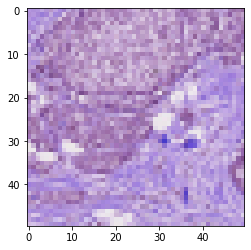

In [26]:
plt.imshow(class1_array[10][0])

In [27]:
combined_data = np.concatenate((class0_array, class1_array))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [28]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [29]:
X = np.array(X).reshape(-1, 50, 50, 3)

In [31]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8197, 50, 50, 3) (2050, 50, 50, 3) (8197, 2) (2050, 2)


In [32]:
import tensorflow as tf
from tensorflow import keras

In [33]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(50,50,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(9216,input_shape=(12544,), activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [34]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall','Precision']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 100)       2800      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 100)      400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       102656    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 256)      1024      
 hNormalization)                                                 
                                                        

In [37]:
history=model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
257/257 [==============================] - 308s 1s/step - loss: 0.3216 - accuracy: 0.8643 - recall: 0.8591 - precision: 0.8577 - val_loss: 0.2875 - val_accuracy: 0.8693 - val_recall: 0.8761 - val_precision: 0.8660
Epoch 2/50
257/257 [==============================] - 305s 1s/step - loss: 0.3070 - accuracy: 0.8717 - recall: 0.8651 - precision: 0.8643 - val_loss: 0.2832 - val_accuracy: 0.8732 - val_recall: 0.8780 - val_precision: 0.8691
Epoch 3/50
257/257 [==============================] - 305s 1s/step - loss: 0.2969 - accuracy: 0.8807 - recall: 0.8754 - precision: 0.8750 - val_loss: 0.2844 - val_accuracy: 0.8795 - val_recall: 0.8839 - val_precision: 0.8762
Epoch 4/50
257/257 [==============================] - 306s 1s/step - loss: 0.2888 - accuracy: 0.8813 - recall: 0.8769 - precision: 0.8795 - val_loss: 0.2783 - val_accuracy: 0.8800 - val_recall: 0.8815 - val_precision: 0.8776
Epoch 5/50
257/257 [==============================] - 309s 1s/step - loss: 0.2833 - accuracy: 0.8848

In [38]:
e=model.evaluate(X_test,y_test)

65/65 [==============================] - 12s 191ms/step - loss: 0.2852 - accuracy: 0.8985 - recall: 0.9010 - precision: 0.8979


In [39]:
print(e[0])

0.28517454862594604


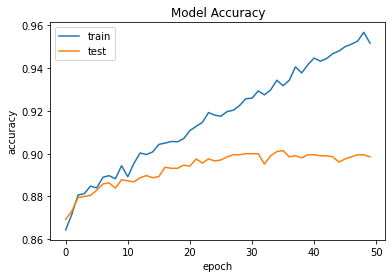

In [40]:
import matplotlib.pyplot as plt

#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

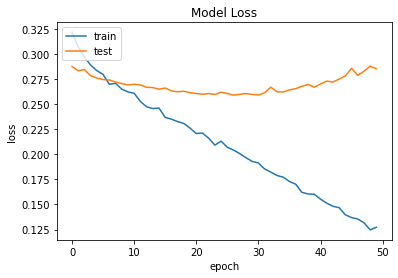

In [41]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
y_pred=model.predict(X_test)

In [43]:
y_pred[21]

array([0.9981824 , 0.00253299], dtype=float32)

In [44]:
y_test[21]

array([1., 0.], dtype=float32)

In [45]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [46]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)

In [47]:
Y_pred[0]

0

In [48]:
Y_test[0]

0

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['IDC(-)','IDC(+)']))

Confusion Matrix
[[1609   96]
 [ 112  233]]
Classification Report
              precision    recall  f1-score   support

      IDC(-)       0.93      0.94      0.94      1705
      IDC(+)       0.71      0.68      0.69       345

    accuracy                           0.90      2050
   macro avg       0.82      0.81      0.82      2050
weighted avg       0.90      0.90      0.90      2050



In [50]:
model.save('/content/input/modelcnn.h5')

In [51]:
confusionmatrix=confusion_matrix(Y_test, Y_pred)

In [52]:
confusionmatrix.shape

(2, 2)

In [53]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),
                     index = classes, 
                     columns = classes)

In [54]:
con_mat_df

,0,1
0,1609,96
1,112,233


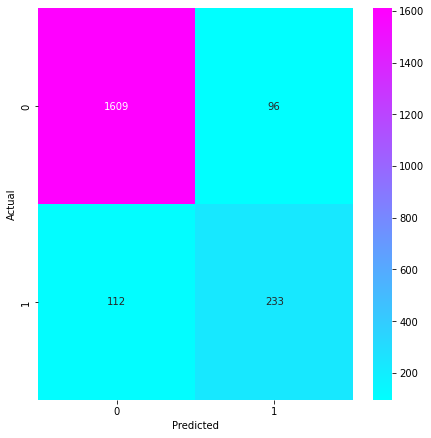

In [55]:
import seaborn as sns

figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()